# EDA of the dataset

### Our datasets
main dataset  - ["European Soccer Database" (ESD)](https://www.kaggle.com/hugomathien/soccer//) 

Additional datasets -

- "UK football stadiums" -  [UK stadiums description](https://www.doogal.co.uk/FootballStadiums.php//) 
- Position in league table per stage - from [worldfootball](https://www.worldfootball.net/schedule//)

The "European Soccer Database" consists of three main tables:
- Match - features for each match of 2008-2016 seasons
- Player -  player attributes
- Team - team attributes

The worldfootball dataset was extracted directly from the website. In order to receive the position of each team in each stage of the league we wrote a script named extract_table_from_url(attached together with this file) which goes through pages such as [this](http://www.worldfootball.net/schedule/eng-premier-league-2016-2017-spieltag/9/) and write the data to an csv file. 



### EDA update 

In this notebook we worked on three issues:
1) Engineering new features 
2) Dealing with draw class poor prediction rates
3) Using Different classification models


#### New features:
- points - number of points in current league stage
- norm_points - number of points in current league stage relative to highest number of points in current stage
- position - position in league table
- straight_wins - if last game was won, number of wins in a row
- straight_loses - if last game was lost, number of losses in a row
- straight_draws - - if last game ended with a draw, number of draws in a row 
- pos_goals - goals scored in last X games
- neg_goals - goals received in last X games
- tot_pos_goals - goals scored since the begining of the season
- tot_neg_goals - goals received since the begining of the season
- goals_diff - tot_pos_goals minus tot_neg_goals
- wins - wins in last X games 
- loses - loses in last X games

X is the size of the moving window we used.
In this file we set X to be 5, in the future we will try different size for X.
All of these features were created for both home and away team for each match. 

#### Draw class:
As we saw on our first attempt classifier, the classifier never chose the draw class, to deal with this issue we tried two methods, both based on demanding a certain threshold crossing for a win/ lose decision:
1) relative threshold - the threshold is determined on the percentage win and lose cases takes out of 1.
2) absolute threshold -  win/lose classed needs to cross a predetermined threshold in order for them to be picked

#### Classification models:

In order to get a perspective of the preformance we can achive, we tried using the following models:
- Logistic Regression
- KNN
- SVM
- Decision Tree
- Random Forest
- A combination of all models

After trying all of these models the best f1-score was received using Logistic Regression with the second type of threshold.



#### General Impotrs:

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Read all DB's:

In [2]:
#main_db = sqlite3.connect('databases/database.sqlite')

In [3]:
#leagues_db = pd.read_sql("SELECT * FROM League", main_db)
leagues_db = pd.read_csv('databases/sql_leagues_db.csv', index_col = [0])
leagues_db.head()

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [4]:
#matches_db         = pd.read_sql("SELECT * FROM Match where league_id=1729", main_db)
matches_db         = pd.read_csv('databases/sql_matches_db.csv', index_col = [0])
matches_db["date"] = matches_db["date"].apply(lambda x: x.split(" ")[0])
matches_db.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1,1730,1729,1729,2008/2009,1,2008-08-16,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
2,1731,1729,1729,2008/2009,1,2008-08-16,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
3,1732,1729,1729,2008/2009,1,2008-08-16,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
4,1733,1729,1729,2008/2009,1,2008-08-17,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [5]:
#teams_db = pd.read_sql("SELECT * FROM Team", main_db)
teams_db = pd.read_csv('databases/sql_teams_db.csv', encoding='latin-1', index_col = [0])
teams_db.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [6]:
league_table_db = pd.read_csv('databases/table_per_stage.csv', index_col = [0,1], header = [0,1], skipinitialspace = True)
league_table_db.head()

Stage                         0                                         \
                            Pts Norm_Pts Position Goals_Diff Pos_Goals   
Season    Team                                                           
2008/2009 Arsenal           0.0      0.0      0.0        0.0       0.0   
          Aston Villa       0.0      0.0      0.0        0.0       0.0   
          Blackburn Rovers  0.0      0.0      0.0        0.0       0.0   
          Bolton Wanderers  0.0      0.0      0.0        0.0       0.0   
          Chelsea           0.0      0.0      0.0        0.0       0.0   

Stage                                   1                               \
                           Neg_Goals  Pts Norm_Pts Position Goals_Diff   
Season    Team                                                           
2008/2009 Arsenal                0.0  3.0      1.0      8.0        1.0   
          Aston Villa            0.0  3.0      1.0      2.0        2.0   
          Blackburn Rovers       0.0  3.0      1.0      4.0        1.0   
          Bolton Wanderers       0.0  3.0      1.0      3.0        2.0   
          Chelsea                0.0  3.0      1.0      1.0        4.0   

Stage                         ...          37                                 \
                              ...    Position Goals_Diff Pos_Goals Neg_Goals   
Season    Team                ...                                              
2008/2009 Arsenal             ...         4.0       28.0      64.0      36.0   
          Aston Villa         ...         6.0        5.0      53.0      48.0   
          Blackburn Rovers    ...        15.0      -20.0      40.0      60.0   
          Bolton Wanderers    ...        13.0      -11.0      41.0      52.0   
          Chelsea             ...         3.0       43.0      65.0      22.0   

Stage                         38                                          \
                             Pts  Norm_Pts Position Goals_Diff Pos_Goals   
Season    Team                                                             
2008/2009 Arsenal           72.0  0.800000      4.0       31.0      68.0   
          Aston Villa       62.0  0.688889      6.0        6.0      54.0   
          Blackburn Rovers  41.0  0.455556     15.0      -20.0      40.0   
          Bolton Wanderers  41.0  0.455556     13.0      -12.0      41.0   
          Chelsea           83.0  0.922222      3.0       44.0      68.0   

Stage                                 
                           Neg_Goals  
Season    Team                        
2008/2009 Arsenal               37.0  
          Aston Villa           48.0  
          Blackburn Rovers      60.0  
          Bolton Wanderers      53.0  
          Chelsea               24.0  

[5 rows x 234 columns]

In [7]:
stadiums_db = pd.read_csv("databases/stadiums_db.csv", index_col = [0], skipinitialspace = True)
stadiums_db.head()

,Team,FDCOUK,City,Stadium,Capacity,Latitude,Longitude,Country
0,Arsenal,Arsenal,London,Emirates Stadium,60361,51.555000,-0.108611,England
1,Aston Villa,Aston Villa,Birmingham,Villa Park,42785,52.509167,-1.884722,England
2,Blackburn Rovers,Blackburn,Blackburn,Ewood Park,31154,53.728611,-2.489167,England
3,Bolton Wanderers,Bolton,Bolton,Reebok Stadium,28100,53.580556,-2.535556,England
4,Chelsea,Chelsea,London,Stamford Bridge,42449,51.481667,-0.191111,England


#### Functions:

In [8]:
def get_opposit(item):
    a = ["home","away"]
    a.remove(item)
    return a[0]

def func1(x,temp_dic,home_away,team):
    temp_dic[home_away]              = x.loc[(x[home_away + "_team_name"] == team)].copy()
    temp_dic[home_away]["home_away"] = home_away
    
def func2(x,temp_dic,home_away,features):
    temp_dic[home_away] = x.loc[(x["home_away"] == home_away)].copy()
    for item in features:
        temp_dic[home_away][home_away + "_" + item] = temp_dic[home_away][item]

def get_df(x,func,func_data):
    temp_dic = {}
    for home_away in ["home", "away"]:
        func(x,temp_dic,home_away,func_data)
    return temp_dic["home"].append(temp_dic["away"]).sort_values(["season","stage"])

def template(df,input_column,output_column,window_size):
    temp_series = df.apply(lambda x: x[x["home_away"] + "_" + input_column],axis = 1)
    df[output_column] = temp_series.rolling(window_size).sum() - temp_series
    
def opposit_template(df,input_column,output_column,window_size):
    temp_series = df.apply(lambda x: x[get_opposit(x["home_away"]) + "_" + input_column],axis = 1)
    df[output_column] = temp_series.rolling(window_size).sum() - temp_series
    
def asi(df,input_column):
    c = 0
    a = []
    for index in df.index:
        if df.at[index,df.at[index,"home_away"] + "_" + input_column] == 1: c += 1
        else: c = 0
        a.append(c)
    return ([0] + a[0:-1])

#### Hyperparameters:

In [9]:
window_size = 5
threshold_1 = 1.5
threshold_2 = {1:0.45,2:0.35}

#### Feature Engeneering:

In [10]:
all_teams_id = matches_db["home_team_api_id"].unique()

teams_map = {}

for team in all_teams_id:
    teams_map[team] = teams_db.loc[teams_db["team_api_id"] == team, "team_long_name"].values[0]

In [11]:
matches_db["home_team_name"] = matches_db["home_team_api_id"].map(teams_map)
matches_db["away_team_name"] = matches_db["away_team_api_id"].map(teams_map)

In [12]:
matches_db["score"] = matches_db["home_team_goal"].astype("str") + " - " + matches_db["away_team_goal"].astype("str")

In [13]:
all_teams   = matches_db["home_team_name"].unique()
all_seasons = matches_db["season"].unique()
all_stages  = matches_db["stage"].unique()

all_teams.sort()
all_seasons.sort()
all_stages.sort()

In [14]:
basic_info       = ["season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","pos_goals","neg_goals","tot_pos_goals","tot_neg_goals","goals_diff","wins","loses"]
important_info   = basic_info + ["home_team_goal","away_team_goal"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

In [15]:
new_matches = matches_db[new_columns].copy()
new_matches.sort_values(["season","stage"],inplace = True)

for index in new_matches.index:
    new_matches.at[index,"stadium_capcity"] = int(stadiums_db.loc[stadiums_db["Team"] == new_matches.at[index,"home_team_name"]]["Capacity"])

for a in home_away:
    new_matches[a + "_win"]  = pd.Series(new_matches[a + "_team_goal"] >  new_matches[get_opposit(a) + "_team_goal"],dtype=int)
    new_matches[a + "_lose"] = pd.Series(new_matches[a + "_team_goal"] <  new_matches[get_opposit(a) + "_team_goal"],dtype=int)
    new_matches[a + "_draw"] = pd.Series(new_matches[a + "_team_goal"] == new_matches[get_opposit(a) + "_team_goal"],dtype=int)
    
new_matches["win_lose_draw"] = new_matches["home_win"] + 2*new_matches["away_win"]

In [16]:
new_matches.head()

,season,stage,home_team_name,away_team_name,score,home_team_goal,away_team_goal,B365H,WHH,VCH,...,WHD,VCD,stadium_capcity,home_win,home_lose,home_draw,away_win,away_lose,away_draw,win_lose_draw
0,2008/2009,1,Manchester United,Newcastle United,1 - 1,1,1,1.29,1.25,1.28,...,4.5,5.5,75811.0,0,0,1,0,0,1,0
1,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,1,0,1.20,1.17,1.25,...,5.5,6.0,60361.0,1,0,0,0,1,0,1
2,2008/2009,1,Sunderland,Liverpool,0 - 1,0,1,5.50,5.50,5.50,...,3.3,3.8,48707.0,0,1,0,1,0,0,2
3,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,2,1,1.91,1.83,1.90,...,3.2,3.5,35303.0,1,0,0,0,1,0,1
4,2008/2009,1,Aston Villa,Manchester City,4 - 2,4,2,1.91,1.91,1.90,...,3.2,3.5,42785.0,1,0,0,0,1,0,1


In [17]:
new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])

for team in all_teams:
    for season in all_seasons:
        matches_per_team        = get_df(new_matches,func1,team)
        matches_per_team_season = matches_per_team[matches_per_team["season"] == season].copy()
        
        if len(matches_per_team_season.index) == 0: continue
                
        template(matches_per_team_season,"team_goal","pos_goals",window_size)
        opposit_template(matches_per_team_season,"team_goal","neg_goals",window_size)
        template(matches_per_team_season,"win","wins",window_size)
        template(matches_per_team_season,"lose","loses",window_size)
        
        temp_series = matches_per_team_season.apply(lambda x: x[x["home_away"] + "_win"],axis = 1)
        matches_per_team_season["straight_wins"]  = asi(matches_per_team_season,"win")
        matches_per_team_season["straight_loses"] = asi(matches_per_team_season,"lose")
        matches_per_team_season["straight_draws"] = asi(matches_per_team_season,"draw")
        
        table_per_team_season                    = league_table_db.transpose()[season,team]
        matches_per_team_season["points"]        = list(table_per_team_season.xs("Pts",level=1)[0:-1])
        matches_per_team_season["norm_points"]   = list(table_per_team_season.xs("Norm_Pts",level=1)[0:-1])
        matches_per_team_season["position"]      = list(table_per_team_season.xs("Position",level=1)[0:-1])
        matches_per_team_season["tot_pos_goals"] = list(table_per_team_season.xs("Pos_Goals",level=1)[0:-1])
        matches_per_team_season["tot_neg_goals"] = list(table_per_team_season.xs("Neg_Goals",level=1)[0:-1])
        matches_per_team_season["goals_diff"]    = list(table_per_team_season.xs("Goals_Diff",level=1)[0:-1])
        
        home_away_goals = get_df(matches_per_team_season,func2,new_features)[new_new_columns]
        
        for index in home_away_goals.index:
            for column in new_new_columns:
                if home_away_goals.at[index,column] != "NaN":
                    new_matches.at[index,column] = home_away_goals.at[index,column]
    
new_matches = new_matches[basic_info + ["stadium_capcity"] + new_new_columns + betting_odds + ["win_lose_draw"]]

In [18]:
new_matches

,season,stage,home_team_name,away_team_name,score,stadium_capcity,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,2008/2009,1,Manchester United,Newcastle United,1 - 1,75811.0,0.0,0.000000,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.50,4.50,5.50,0
1,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,60361.0,0.0,0.000000,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.50,5.50,6.00,1
2,2008/2009,1,Sunderland,Liverpool,0 - 1,48707.0,0.0,0.000000,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.60,3.30,3.80,2
3,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,35303.0,0.0,0.000000,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.40,3.20,3.50,1
4,2008/2009,1,Aston Villa,Manchester City,4 - 2,42785.0,0.0,0.000000,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.40,3.20,3.50,1
5,2008/2009,1,Everton,Blackburn Rovers,2 - 3,40157.0,0.0,0.000000,0.0,0.0,...,2.00,1.95,2.05,4.00,3.50,4.00,3.30,3.10,3.30,2
6,2008/2009,1,Middlesbrough,Tottenham Hotspur,2 - 1,34988.0,0.0,0.000000,0.0,0.0,...,3.20,2.90,3.20,2.25,2.15,2.30,3.40,3.20,3.40,1
7,2008/2009,1,Bolton Wanderers,Stoke City,3 - 1,28100.0,0.0,0.000000,0.0,0.0,...,1.83,1.80,1.85,4.50,4.00,4.80,3.50,3.10,3.40,1
8,2008/2009,1,Hull City,Fulham,2 - 1,25404.0,0.0,0.000000,0.0,0.0,...,2.60,2.50,2.60,2.80,2.62,2.80,3.20,2.90,3.40,1
9,2008/2009,1,Chelsea,Portsmouth,4 - 0,42449.0,0.0,0.000000,0.0,0.0,...,1.33,1.30,1.33,10.00,8.50,11.00,5.00,4.20,5.00,1


In [19]:
new_matches.to_csv("databases/my_matches_db.csv")

#### Data Visualizations:

In [20]:
#sns.pairplot(new_matches[new_new_columns].dropna(axis=0))

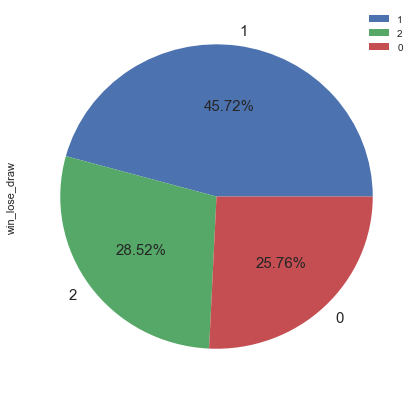

In [21]:
new_matches["win_lose_draw"].value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

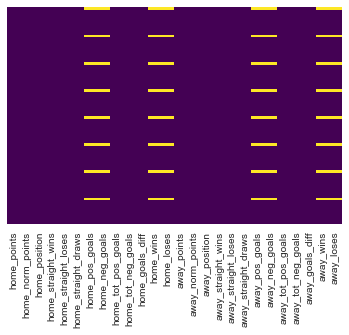

In [22]:
sns.heatmap(new_matches[new_new_columns].isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### Split the data:

In [23]:
temp     = new_matches.dropna(axis = 0)
features = temp[new_new_columns + betting_odds]# + ["stage"] + ["stadium_capcity"]]
labels   = temp["win_lose_draw"]

In [24]:
print("Num of features =",len(features.columns))

Num of features = 35


In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.40, random_state=103)

####  Logistic Regression model

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
logmodel = LogisticRegression()

In [29]:
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
predictions = logmodel.predict(X_test)

#### Learning Evaluation:

In [31]:
from sklearn.metrics import classification_report,confusion_matrix

In [32]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.22      0.05      0.08       264
          1       0.54      0.82      0.65       504
          2       0.51      0.42      0.46       320

avg / total       0.46      0.52      0.46      1088



In [33]:
print(confusion_matrix(y_test,predictions))

[[ 13 193  58]
 [ 19 415  70]
 [ 26 159 135]]


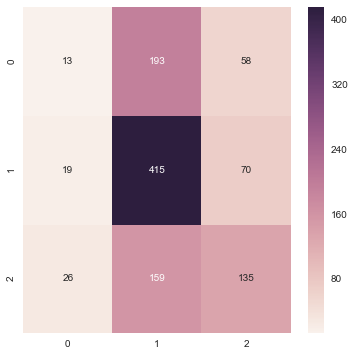

In [34]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True, fmt="d")

In [35]:
coeff_df = pd.DataFrame(logmodel.coef_.T,features.columns,
                        columns=['Coefficient_home','Coefficient_away','Coefficient_draw'])
coeff_df

,Coefficient_home,Coefficient_away,Coefficient_draw
home_points,0.002222,0.000411,-0.003469
home_norm_points,-0.006700,0.122811,-0.278465
home_position,-0.027491,0.047887,-0.038359
home_straight_wins,-0.050447,-0.012734,0.073602
home_straight_loses,-0.011146,-0.052553,0.059266
home_straight_draws,0.065965,-0.056375,-0.010053
home_pos_goals,-0.060492,0.022053,0.042609
home_neg_goals,0.031482,-0.038968,0.009092
home_tot_pos_goals,-0.001375,0.007716,-0.009978
home_tot_neg_goals,0.005821,-0.000518,-0.005849


#### Adding thresold to Logistic Regression model

In [36]:
soft_decision = logmodel.predict_proba(X_test)

In [37]:
def thresh_1(probs,threshold):
    decision  = -1
    if max(probs) == probs[0]: decision = 0
    else:
        home_away_probs = list(probs[[1,2]])
        if max(home_away_probs) > threshold*min(home_away_probs): decision = (home_away_probs.index(max(home_away_probs)) + 1)
    if decision == -1: decision = 0
    return decision

def thresh_2(probs,threshold):
    decision  = -1
    if    probs[1] > threshold[1]: decision = 1
    elif  probs[2] > threshold[2]: decision = 2
    else:                          decision = 0
    return decision

In [38]:
new_predictions = {"threshold_1":[],"threshold_2":[]}

for aa in range(len(soft_decision)):
    new_predictions["threshold_1"].append(thresh_1(soft_decision[aa],threshold_1))
    new_predictions["threshold_2"].append(thresh_2(soft_decision[aa],threshold_2))

In [39]:
for thresh,prediction in new_predictions.items():
    print("threshold =",thresh)
    print(classification_report(y_test,prediction))
    print(confusion_matrix(y_test,prediction),"\n\n")

threshold = threshold_2
             precision    recall  f1-score   support

          0       0.31      0.31      0.31       264
          1       0.60      0.64      0.62       504
          2       0.51      0.45      0.48       320

avg / total       0.50      0.51      0.50      1088

[[ 83 118  63]
 [106 323  75]
 [ 82  94 144]] 


threshold = threshold_1
             precision    recall  f1-score   support

          0       0.27      0.26      0.26       264
          1       0.59      0.73      0.65       504
          2       0.52      0.34      0.41       320

avg / total       0.49      0.50      0.49      1088

[[ 69 144  51]
 [ 87 369  48]
 [101 110 109]] 




#### Adding more models:

In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### KNN:

In [41]:
error_rate = []

for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

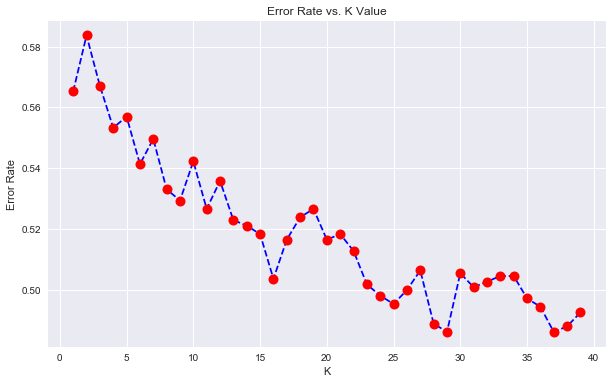

In [42]:
plt.figure(figsize = (10,6))
plt.plot(range(1,40), error_rate, color = 'blue', linestyle = 'dashed', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [43]:
best_n_neighbors = error_rate.index(min(error_rate))
print("best_n_neighbors =",best_n_neighbors)

best_n_neighbors = 28


In [44]:
knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)

#### SVM:

In [45]:
svm = SVC()

In [46]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001]} 
svm_grid   = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

#### Decision Tree:

In [47]:
dtree = DecisionTreeClassifier()

In [48]:
rfc = RandomForestClassifier(n_estimators=600)

#### Train and Predict using all model:

In [49]:
all_models         = [knn,svm,svm_grid,rfc,dtree]
models_predictions = {}

models_predictions[str(logmodel).split("(")[0]] = new_predictions["threshold_2"]

for model in all_models:
    classifier_name = str(model).split("(")[0]
    model.fit(X_train,y_train)
    models_predictions[classifier_name] = model.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] gamma=1, C=0.1 ..................................................
[CV] ................... gamma=1, C=0.1, score=0.462385, total=   0.1s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.463235, total=   0.1s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s


[CV] ................... gamma=1, C=0.1, score=0.464088, total=   0.1s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.462385, total=   0.0s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.463235, total=   0.1s
[CV] gamma=0.1, C=0.1 ................................................
[CV] ................. gamma=0.1, C=0.1, score=0.464088, total=   0.0s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.462385, total=   0.0s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.463235, total=   0.0s
[CV] gamma=0.01, C=0.1 ...............................................
[CV] ................ gamma=0.01, C=0.1, score=0.464088, total=   0.0s
[CV] gamma=0.001, C=0.1 ..............................................
[CV] .

[CV] .................. gamma=1, C=1000, score=0.462385, total=   0.1s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.463235, total=   0.1s
[CV] gamma=1, C=1000 .................................................
[CV] .................. gamma=1, C=1000, score=0.464088, total=   0.1s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.464220, total=   0.1s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.465074, total=   0.0s
[CV] gamma=0.1, C=1000 ...............................................
[CV] ................ gamma=0.1, C=1000, score=0.464088, total=   0.1s
[CV] gamma=0.01, C=1000 ..............................................
[CV] ............... gamma=0.01, C=1000, score=0.425688, total=   0.0s
[CV] gamma=0.01, C=1000 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   17.9s finished


In [50]:
for model_name,model_prediction in models_predictions.items():
    print("classifier =",model_name)
    print(classification_report(y_test,model_prediction))
    print(confusion_matrix(y_test,model_prediction),"\n\n")

classifier = RandomForestClassifier
             precision    recall  f1-score   support

          0       0.22      0.09      0.13       264
          1       0.56      0.78      0.66       504
          2       0.50      0.44      0.47       320

avg / total       0.46      0.51      0.47      1088

[[ 25 168  71]
 [ 43 394  67]
 [ 44 136 140]] 


classifier = LogisticRegression
             precision    recall  f1-score   support

          0       0.31      0.31      0.31       264
          1       0.60      0.64      0.62       504
          2       0.51      0.45      0.48       320

avg / total       0.50      0.51      0.50      1088

[[ 83 118  63]
 [106 323  75]
 [ 82  94 144]] 


classifier = KNeighborsClassifier
             precision    recall  f1-score   support

          0       0.35      0.18      0.24       264
          1       0.55      0.77      0.64       504
          2       0.48      0.37      0.42       320

avg / total       0.48      0.51      0.48      10

In [51]:
# models: rfc/knn/logmodel/dtree/svm/svm_grid
chosen_model = rfc
chosen_data  = X_test
soft_decision = chosen_model.predict_proba(chosen_data)
hard_decision = chosen_model.predict(chosen_data)

In [52]:
soft_decision_df = pd.DataFrame(soft_decision,index = chosen_data.index,columns = ["MYD","MYH","MYA"])
hard_decision_df = pd.DataFrame(hard_decision,index = chosen_data.index)
#soft_decision_df["predictions"] = hard_decision_df[0]

soft_decision_df.to_csv("databases/my_predictions.csv")

#### Combine all predictions:

In [53]:
"""asi = {}
asi["LogisticRegression"] = models_predictions["LogisticRegression"]
asi["GridSearchCV"] = models_predictions["GridSearchCV"]
asi["RandomForestClassifier"] = models_predictions["RandomForestClassifier"]"""

'asi = {}\nasi["LogisticRegression"] = models_predictions["LogisticRegression"]\nasi["GridSearchCV"] = models_predictions["GridSearchCV"]\nasi["RandomForestClassifier"] = models_predictions["RandomForestClassifier"]'

In [54]:
"""num_of_clasifers  = len(asi)
len_of_prediction = len(X_test)

all_predictions = np.concatenate(list(asi.values()),axis=0)
all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T"""

'num_of_clasifers  = len(asi)\nlen_of_prediction = len(X_test)\n\nall_predictions = np.concatenate(list(asi.values()),axis=0)\nall_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T'

In [55]:
num_of_clasifers  = len(models_predictions)
len_of_prediction = len(X_test)

all_predictions = np.concatenate(list(models_predictions.values()),axis=0)
all_predictions = all_predictions.reshape(num_of_clasifers,len_of_prediction).T

In [56]:
final_predictions = []
for i in range(0,len_of_prediction):
    predicted_class,count = np.unique(all_predictions[i],return_counts=True)
    dic = dict(zip(predicted_class,count))
    if 0 in list(dic) and dic[0] > 1: final_class = 0
    else: final_class = max(dic)
    final_predictions.append(final_class)

In [57]:
print(classification_report(y_test,final_predictions))
print(confusion_matrix(y_test,final_predictions))

             precision    recall  f1-score   support

          0       0.28      0.19      0.23       264
          1       0.60      0.57      0.58       504
          2       0.40      0.54      0.46       320

avg / total       0.46      0.47      0.46      1088

[[ 51 105 108]
 [ 68 285 151]
 [ 60  87 173]]


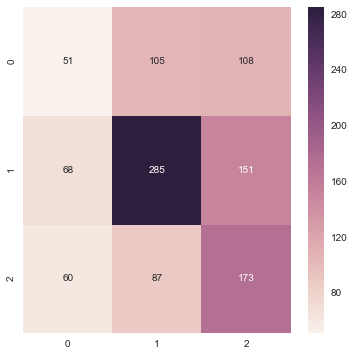

In [58]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,final_predictions),annot=True, fmt="d")

#### Nueral Network model

In [59]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=103)
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Dropout
from sklearn import preprocessing

L = [100,100]
dim = len(features.columns)
k = 3
nb_epoch = 5
batch_size = 1500
dropout = 0.5
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()
Y_train = np_utils.to_categorical(y_train, k)
Y_test = np_utils.to_categorical(y_test, k)

In [61]:
# normalizer = preprocessing.Normalizer().fit(X_train)
# X_train_norm = normalizer.transform(X_train)                            
# X_test_norm = normalizer.transform(X_test)    
X_train.max()

97.0

In [62]:
model = Sequential()
model.add(Dense(L[0], input_dim=dim, init='normal', activation='relu'))
model.add(Dropout(dropout))
for ii in range(1,len(L)):
    model.add(Dense(L[ii], init='normal', activation='relu'))
    model.add(Dropout(dropout))
model.add(Dense(k, init='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="normal", activation="relu", input_dim=35)`
  
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="normal", activation="relu")`
  """
C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal", activation="softmax")`
  import sys


In [63]:
model.fit(X_train, Y_train, nb_epoch=nb_epoch, batch_size=batch_size,validation_data=(X_test, Y_test),shuffle=True)

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\keras\models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1904 samples, validate on 816 samples
Epoch 1/5
1904/1904 [==============================] - 30s - loss: 1.3819 - categorical_accuracy: 0.4133 - val_loss: 1.0322 - val_categorical_accuracy: 0.4865
Epoch 2/5
1904/1904 [==============================] - 35s - loss: 1.2178 - categorical_accuracy: 0.3950 - val_loss: 1.0531 - val_categorical_accuracy: 0.4841
Epoch 3/5
1904/1904 [==============================] - 31s - loss: 1.1654 - categorical_accuracy: 0.4128 - val_loss: 1.0475 - val_categorical_accuracy: 0.4939
Epoch 4/5
1904/1904 [==============================] - 34s - loss: 1.1575 - categorical_accuracy: 0.4049 - val_loss: 1.0289 - val_categorical_accuracy: 0.5245
Epoch 5/5
1904/1904 [==============================] - 35s - loss: 1.0897 - categorical_accuracy: 0.4575 - val_loss: 1.0182 - val_categorical_accuracy: 0.5147


In [64]:
final_predictions = model.predict_classes(X_test, verbose=1)
print(classification_report(y_test,final_predictions))
print(confusion_matrix(y_test,final_predictions))

816/816 [==============================] - 5s     
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       194
          1       0.54      0.82      0.65       379
          2       0.46      0.45      0.46       243

avg / total       0.39      0.51      0.44       816

[[  0 133  61]
 [  0 310  69]
 [  0 133 110]]


C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


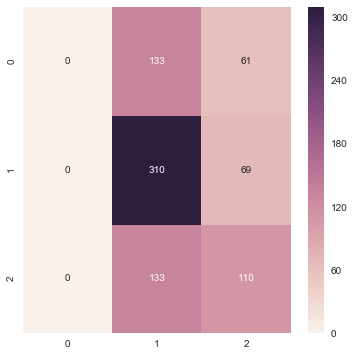

In [65]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test,final_predictions),annot=True, fmt="d")